In [1]:
from datasets import Dataset
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch
from trl import setup_chat_format
import re
import time

/home/alopez/anaconda3/envs/llm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-07 15:44:48.035837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 15:44:48.048834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 15:44:48.052832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 15:44:48.066438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlo

## 1.Load model and tokenizer

In [2]:
base_model = "meta-llama/Llama-3.2-3B-Instruct"
new_model = "andrealopez/Llama-3.2-3B-Instruct-Pima-Diabetes-Clasification"

# Reload tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(base_model)

base_model_reload= AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="auto",
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.91s/it]


In [33]:
# Merge adapter with base model
base_model_reload, tokenizer = setup_chat_format(base_model_reload, tokenizer)
model = PeftModel.from_pretrained(base_model_reload, new_model)
model = model.merge_and_unload()

## 2.Load and serialize data

In [ ]:
def serialize_data(row):
    features_text = " ".join([
        f"The {col} is {str(row[col])}." for col in feature_columns
    ])
    prompt = f"Health values: {features_text}".strip()
    return prompt

def few_shot_prompt(instruction, df_shots): 
    instruction += "Here are some examples.\n"
    messages = [{"role": "system", "content": instruction}]
    for index,row in df_shots.iterrows():
        serialized_row = row.serialized_row
        messages.extend([
            {"role": "user", "content": serialized_row},
            ## PIMA
            {"role": "assistant", "content": f"Outcome: {row[target_column]}"}
        ])
    return messages

In [ ]:
## PIMA
# Preprocess dataset
test_dataset = pd.read_csv('./PIMA_dataset/test_data.csv')
print("Test dataset shape",test_dataset.shape)

# Serialize data
target_column = "Outcome"
feature_columns = [col for col in test_dataset.columns if col != target_column]
test_dataset["serialized_row"] = test_dataset.apply(serialize_data, axis=1)

instruction = f"""You are a doctor specialised in classifying patients as diabetic or non-diabetic based on their health values. Instruction: Respond only with '0' for non-diabetic or '1' for diabetic. Use the following output format: 'Outcome: 0'."""


In [ ]:
# Few-shot
few_shot = True
k_shots = 6
if few_shot: 
    # Shots # TODO: coger las muestras de train o validation
    df_shots = test_dataset.sample(n=k_shots, random_state=42)
    test_dataset = test_dataset.drop(df_shots.index)
    # Few shot prompting
    base_messages = few_shot_prompt(instruction,df_shots)

    # PIMA
    base_messages.append(
        {"role": "system", "content": f"Predict the {target_column} of the next patient."}
    )
    
else: 
    # PIMA
    instruction += f" Predict the {target_column} of the next patient."
    base_messages = [
        {"role": "system", "content": instruction}
    ]

# Convert to HuggingFace datasets
# PIMA -> OUTCOME
serialized_test_data = Dataset.from_pandas(test_dataset[["serialized_row","Outcome"]])

Test dataset shape (154, 9)


## 3.Inference

In [ ]:
def postprocess_pima_inference(text, instance, real_values, output_values):
    pattern = r"assistant\s+Outcome:\s*([01])"
    # Buscar todas las coincidencias
    matches = re.findall(pattern, text)
    if matches:
        # Obtener el último resultado
        predicted_outcome = matches[-1]
        if int(predicted_outcome) not in [0,1]: 
            print("Outcome not in [0,1]: ", predicted_outcome)
            print(text)
        # Solo guardo los que están bien predichos TODO: cambiar esto? tener todos los resultados
        else: 
            output_values.append(int(predicted_outcome))
            real_values.append(instance["Outcome"])
    else:
        print("Not sample match founded.")
        print(text)
    
    return real_values, output_values

In [ ]:
real_values = []
output_values = []
inference_times = []

for instance in serialized_test_data:
    serialized_row = instance["serialized_row"]
    messages = base_messages.copy()

    print("Creating prompt...")
    messages.extend([
        {"role": "user", "content": serialized_row}
    ])

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True).to("cuda")

    print("Inferring...")
    start_time = time.time()
    outputs = model.generate(**inputs, max_new_tokens=10, num_return_sequences=1)
    end_time = time.time()
    inference_time = end_time - start_time
    inference_times.append(inference_time)
    print(inference_time)
    
    print("Decoding...")
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Postprocessing

    ## 1. PIMA
    real_values, output_values = postprocess_pima_inference(text, instance, real_values, output_values)

Creating prompt...
Inferring...
0.394773006439209
Decoding...
Creating prompt...
Inferring...
0.38793301582336426
Decoding...
Creating prompt...
Inferring...
0.39067554473876953
Decoding...
Creating prompt...
Inferring...
0.39318323135375977
Decoding...
Creating prompt...
Inferring...
0.39180850982666016
Decoding...
Creating prompt...
Inferring...
0.3883204460144043
Decoding...
Creating prompt...
Inferring...
0.4154055118560791
Decoding...
Creating prompt...
Inferring...
0.40970849990844727
Decoding...
Creating prompt...
Inferring...
0.40986180305480957
Decoding...
Creating prompt...
Inferring...
0.4013404846191406
Decoding...
Creating prompt...
Inferring...
0.3977222442626953
Decoding...
Creating prompt...
Inferring...
0.39464616775512695
Decoding...
Creating prompt...
Inferring...
0.3955190181732178
Decoding...
Creating prompt...
Inferring...
0.39946556091308594
Decoding...
Creating prompt...
Inferring...
0.40167856216430664
Decoding...
Creating prompt...
Inferring...
0.3988413810729

In [56]:
from collections import Counter
print(Counter(real_values))
print(Counter(output_values))

Counter({0: 92, 1: 56})
Counter({0: 92, 1: 56})


In [57]:
# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def inference_results(real_values, predicted_values,base_model,new_model,inference_times,instruction,test_dataset):
    metrics = {
        "accuracy": accuracy_score(real_values, predicted_values),
        "precision": precision_score(real_values, predicted_values, average='weighted'),
        "recall": recall_score(real_values, predicted_values, average='weighted'),
        "f1_score": f1_score(real_values, predicted_values, average='weighted'),
        "base_model": base_model,
        "finetuned_model": new_model,
        "few_shot": "6-shot",
        "inference_times" : inference_times,
        "instruction":instruction,
        "dataset": "PIMA",
        "train_size": 491,
        "validation_size": 123,
        "test_size" : len(test_dataset),
        
    }
    return metrics

results = inference_results(real_values, output_values,base_model,new_model,inference_times,instruction,test_dataset)
results

{'accuracy': 0.6891891891891891,
 'precision': 0.6891891891891891,
 'recall': 0.6891891891891891,
 'f1_score': 0.6891891891891891,
 'base_model': 'meta-llama/Llama-3.2-3B-Instruct',
 'finetuned_model': 'andrealopez/Llama-3.2-3B-Instruct-Pima-Diabetes-Clasification',
 'few_shot': '6-shot',
 'inference_times': [0.394773006439209,
  0.38793301582336426,
  0.39067554473876953,
  0.39318323135375977,
  0.39180850982666016,
  0.3883204460144043,
  0.4154055118560791,
  0.40970849990844727,
  0.40986180305480957,
  0.4013404846191406,
  0.3977222442626953,
  0.39464616775512695,
  0.3955190181732178,
  0.39946556091308594,
  0.40167856216430664,
  0.39884138107299805,
  0.39249753952026367,
  0.39287495613098145,
  0.40345072746276855,
  0.3997812271118164,
  0.40211057662963867,
  0.40396547317504883,
  0.4014253616333008,
  0.4062459468841553,
  0.4013345241546631,
  0.4037201404571533,
  0.40366029739379883,
  0.3943159580230713,
  0.3970301151275635,
  0.39437007904052734,
  0.39285659790

In [58]:
import json
with open('./PIMA_dataset/inference_metrics_llama3.2_3B_6shot_4_11_2024.json', 'w') as file:
    json.dump(results, file, indent=4)

Tiempo promedio de inferencia por instancia: 0.2166 segundos


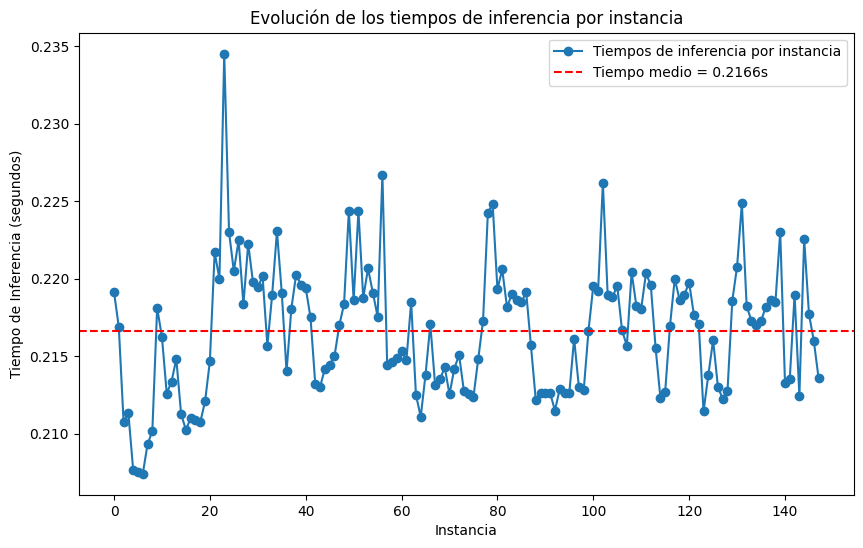

In [31]:
import matplotlib.pyplot as plt
import numpy as np

average_inference_time = np.mean(inference_times)
print(f"Tiempo promedio de inferencia por instancia: {average_inference_time:.4f} segundos")

# Graficar la evolución de los tiempos de inferencia
plt.figure(figsize=(10, 6))
plt.plot(inference_times, label='Tiempos de inferencia por instancia', marker='o')
plt.axhline(y=average_inference_time, color='r', linestyle='--', label=f'Tiempo medio = {average_inference_time:.4f}s')
plt.xlabel('Instancia')
plt.ylabel('Tiempo de Inferencia (segundos)')
plt.title('Evolución de los tiempos de inferencia por instancia')
plt.legend()
plt.show()